## Predicción de series temporales en Python

Para explicar cómo podemos hacer predicción sobre series temporales, utilizaremos un famoso conjunto de datos sobre la evolución del número de pasajeros en una famosa aerolínea americana desde 1949 a 1960.

In [53]:

### import seaborn as sns
### import pandas as pd

import logging
import pickle
import itertools

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.graphics.tsaplots import (
#     plot_acf,
#     plot_pacf
# )
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error
# logger = logging.getLogger()
# logger.setLevel(logging.ERROR)


### Paso 1. Lectura del conjunto de datos

In [54]:
import seaborn as sns

df_raw = sns.load_dataset("flights")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [55]:
df_raw.sample(10,random_state=2025)

,year,month,passengers
2,1949,Mar,132
82,1955,Nov,237
77,1955,Jun,315
26,1951,Mar,178
23,1950,Dec,140
44,1952,Sep,209
54,1953,Jul,264
0,1949,Jan,112
5,1949,Jun,135
108,1958,Jan,340


El conjunto de datos en crudo nos serviría para realizar un proceso de Machine Learning usual como los que hemos visto en pasados módulos.  
En esta ocasión, necesitamos aplicar una transformación del mismo para generar una serie temporal con dos dimensiones: 
*   la temporal y 
*   la del dato que queremos analizar y predecir.  

En este caso,  
la dimensión temporal estará compuesta por
*   el mes (`month`) y 
*   el año (`year`) 
el dato que observaremos a lo largo del tiempo será 
* el número de pasajeros (`passengers`).

In [56]:
import pandas as pd

df_baking = df_raw.copy()
    # Crea una copia independiente del DataFrame original df_raw, llamada df_baking,
    # para trabajar con ella sin modificar el original.

df_baking['month'] = pd.to_datetime(df_baking['month'], format='%b').dt.month
print ("✔️Meses Transformados:\n", *df_baking['month'].unique())
    # Convierte el nombre del mes abreviado ("Jan", "Feb", etc.) en un número
    # (1 para enero, 2 para febrero, ..., 12 para diciembre).
    # El resultado se guarda en la misma columna "month" (sobrescribiéndola).

    # 📌 format='%b' le dice a pd.to_datetime que el mes está en formato abreviado.
    # 📌 .dt.month extrae el número de mes del objeto datetime.

df_baking['date'] = pd.to_datetime(df_baking[['year','month']].assign(day=1))
    # Crea una nueva columna "date" combinando "year" y "month", asignando el 
    # día 1 por defecto (porque no hay día en los datos).
    # Luego lo convierte a un objeto de fecha completo (datetime64).

    # 📌 pd.to_datetime(...).assign(day=1) crea una fecha como 2022-05-01 por ejemplo.

df_baking = df_baking.set_index('date')
print ("✔️Columna Date Creada como Index: \n", (df_baking.index).unique()) 
  
    # Convierte la columna "date" en el índice del DataFrame. Esto es muy común 
    # en análisis de series temporales, porque facilita operaciones como resampling,
    # plotting, etc.


df_baking = df_baking["passengers"].to_frame()
    # Selecciona solo la columna "passengers", conviertiendola en un DataFrame 
    # de una sola columna, y manteniendo el índice de fechas que se estableció 
    # en el paso anterior.
    # to_frame() convierte una Serie en un DataFrame, manteniendo el índice.


df = df_baking.copy()
print("✔️df_Sample:\n", df.sample(10,random_state=2025))


✔️Meses Transformados:
 1 2 3 4 5 6 7 8 9 10 11 12
✔️Columna Date Creada como Index: 
 DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='date', length=144, freq=None)
✔️df_Sample:
             passengers
date                  
1949-03-01         132
1955-11-01         237
1955-06-01         315
1951-03-01         178
1950-12-01         140
1952-09-01         209
1953-07-01         264
1949-01-01         112
1949-06-01         135
1958-01-01         340


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 6.3 KB


### Machine Learning: 
Veremos la escencia del Modelo de Machine Learning para Series de Tiempo.

![alt text](image.png)


> **PARTICION DEL DATASET:** 
* **Sector Train (Pasado):**    
Para hacer forecasting Machine Learning, voy a obervar el compportamiento del pasado tomando el grupo de datos de entrenamiento (train), para luego predecir el futuro.  
* **Sector Test (Ultimo Periodo con Datos):**  
Tambien voy a necesitar el grupo de datos de prueba (test), que son datos ya conocidos, ubicados al final de mi serie temporal.  
Con ellos vere si estoy cumpliendo con la prediccion, y asi extrapolarla para predecir entonces el futuro. 
* **Sector Prediccion (Futuro)** 
El futuro vendria despues del test. 

> **CARACTERISTICAS DEL DATASET: (Verde)** 
* Tendencia (Positiva o Negativa)
* Sesonality (Curbas Periodicas)

> **RESIDUALES: (Naranja)**
Es la diferencia que hay entre mi prediccion y la realidad.
Si hago una prediccion de linea del tiempo, tratando de ajustarme lo mas posible a la linea de los datos reales, me encontrare con diferencias entre ambas curbas. Esas diferencias son los errores de prediccion que llamare residuales. 

#### **Step 1: EDA** Separo Datos

In [65]:
# CREAMOS EL DATASET DE PRUEBA Y ENTRENAMIENTO
# ---------------------------------------------------

# Los Ultimos 12 Meses los dejaremos como TEST, y el resto como TRAIN
# Para esto usaremos un sliceo de pandas, que nos permite seleccionar filas
# y columnas, donde 
# el primer ":" indica el rango de filas y 
# el segundo ":" indica el rango de columnas.
# df.iloc[filas, columnas]


df_train = df.iloc[:-12,:] # Selecciona todas las filas excepto las últimas 12 del DataFrame df.
print("✔️df_train Sample:\n", df_train.sample(10,random_state=2025))
    # :-12 significa "desde el inicio hasta 12 filas antes del final".
    # : después de la coma indica "todas las columnas".
    # Resultado: las primeras len(df) - 12 filas.

df_test = df.iloc[-12:,:] # Selecciona solo las últimas 12 filas del DataFrame df.
print("\n✔️df_test Sample:\n", df_test.sample(10,random_state=2025))
    # -12: significa "desde la fila número 12 desde el final hasta el final".
    # : indica todas las columnas.
    # Resultado: las últimas 12 filas



✔️df_train Sample:
             passengers
date                  
1953-01-01         196
1950-08-01         170
1954-04-01         227
1954-07-01         302
1958-06-01         435
1952-02-01         180
1959-10-01         407
1951-06-01         178
1953-11-01         180
1949-03-01         132

✔️df_test Sample:
             passengers
date                  
1960-11-01         390
1960-06-01         535
1960-02-01         391
1960-08-01         606
1960-12-01         432
1960-07-01         622
1960-01-01         417
1960-05-01         472
1960-10-01         461
1960-04-01         461


#### **Step 1: EDA** Analisis Estadistico

In [66]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
passengers,132.0,262.5,106.6,104.0,176.5,239.5,343.2,559.0


In [67]:
# Tenemos 132 Observaciones, ya que reducimos el dataset sacandole 12 meses para el test.
# La media de pasajeros es 262, con un mínimo de 104 y un máximo de 559.
# La desviación estándar es 106, lo que indica que hay una gran variabilidad en el número de pasajeros.
# La mediana esta en 239, lo que indica que la mitad de los meses tienen menos de 239 pasajeros y la otra mitad más.
# La mediana esta bastante cerca de la media, lo que indica que la distribución es bastante simétrica.
# Veremos una distribucion que tiene cierta desviacion

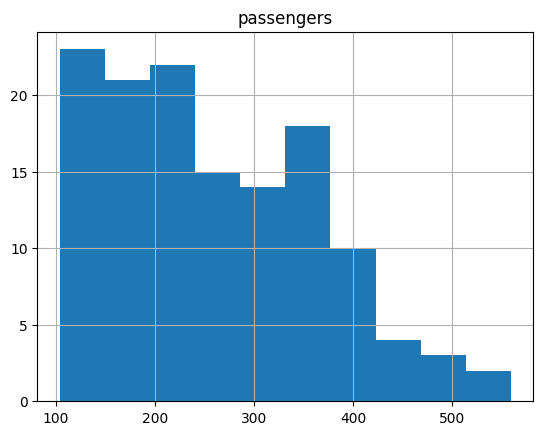

In [69]:
# HISTOGRAMA
df_train.hist()
plt.show()

In [ ]:
# Los datos mas representativos, los que vemos con mas frecuencia, estan entre 100 y 200
# y los que menos frecuencia tienen van del 300 hacia adelante.
# Veremos seguramente algo distinto a lo que venimos acostumbrados, en la distribucion de los datos, 
# que en general es la forma de una campana. 
# Lo mas probable es que tenga tendencia.
# Para averiguarlo vamos a graficar la serie temporal.



#### **Step 1: EDA** Analisis Visual de la Serie Temporal

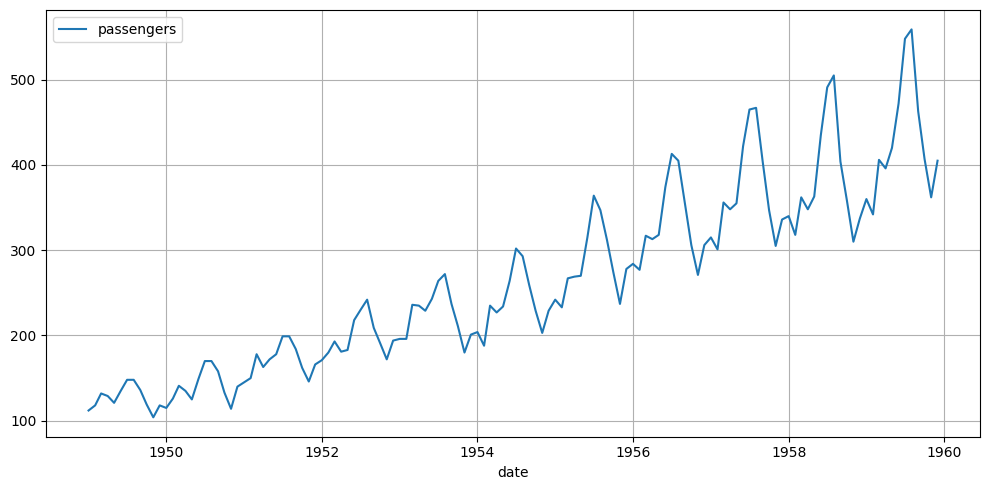

In [71]:
# GRAFICAMOS LA SERIE TEMPORAL para llevar a cabo un análisis visual de la misma

import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(df_train)
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
decomposition = seasonal_decompose(df['passengers'],period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
sns.lineplot(df_train)
sns.lineplot(trend,label='trend')
sns.lineplot(seasonal,label='seasonal')
sns.lineplot(residual,label='residual')
plt.grid(True)
plt.show()




NameError: name 'seasonal_decompose' is not defined

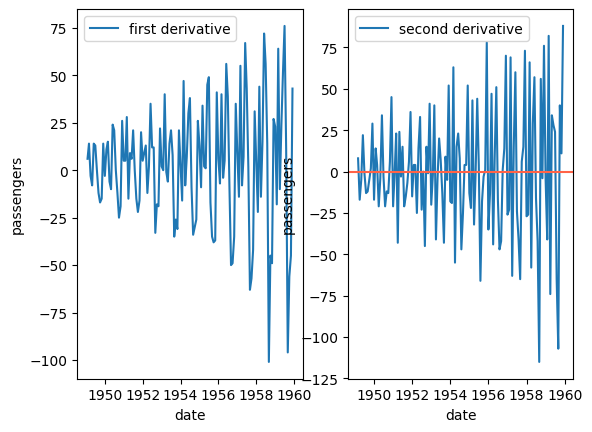

In [ ]:
# d = stationarity, data points have no trend
fig,ax=plt.subplots(1,2)
sns.lineplot(df_train['passengers'].diff(),label='first derivative',ax=ax[0])
sns.lineplot(df_train['passengers'].diff().diff(),label='second derivative',ax=ax[1])
plt.axhline(0,color='tomato')
plt.show()

In [ ]:
# alpha = 0.05 if the p value is above alpha then we can say that it is not stationary (it has trend)
# if p value < alpha then we can rule out that it is stationary  (it has no trend)
ad_fuller = adfuller(df_train)
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: 0.89
adf P Value: 0.99


In [ ]:
ad_fuller = adfuller(df_train['passengers'].diff().dropna())
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -2.40
adf P Value: 0.14


In [ ]:
ad_fuller = adfuller(df_train['passengers'].diff().diff().dropna())
print(f'adf statistic: {ad_fuller[0]:.2f}')
print(f'adf P Value: {ad_fuller[1]:.2f}')

adf statistic: -14.25
adf P Value: 0.00


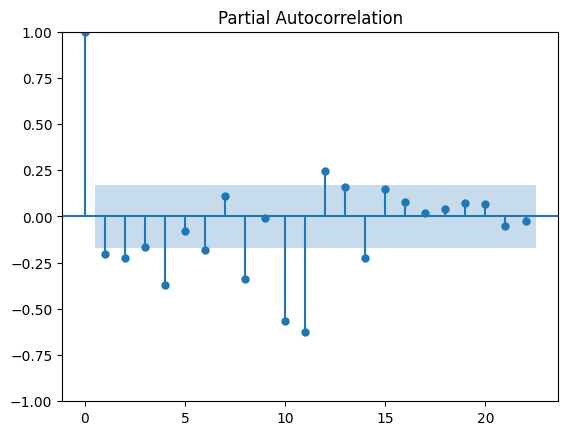

In [ ]:
# value p is the autoregressive term - autoregressive = seasonality
plot_pacf(df_train.diff().diff().dropna())
plt.show()

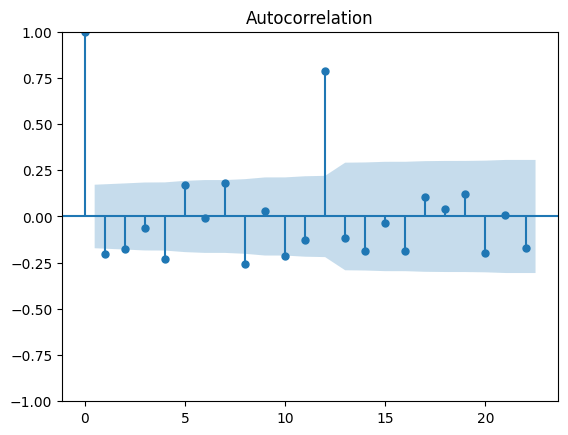

In [ ]:
# q is the moving average
plot_acf(df_train.diff().diff().dropna())
plt.show()

In [ ]:
arima = ARIMA(df['passengers'],order=(2,1,2)) # order variables above 'd' (differencing),'p' (partial autocorrelation), 'q' (moving average) the goal in setting these is to make the P>|z| to be the lowest possible. find the lowest AIC or P>|z| for highest precision
ts_arima = arima.fit()
print(ts_arima.summary())

/workspaces/4Geeks_Classes/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/workspaces/4Geeks_Classes/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Thu, 06 Mar 2025   AIC                           1353.347
Time:                        04:03:24   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.060      0.000       1.645       1.725
ar.L2         -0.9548      0.017    -55.420      0.000      -0.989      -0.921
ma.L1         -1.8432      0.124    -14.814      0.0

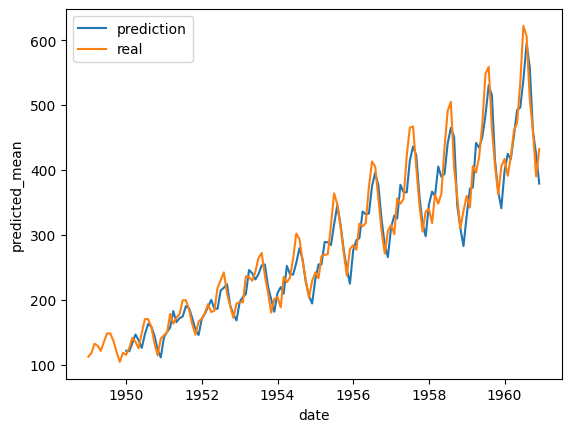

In [ ]:
y_hat = ts_arima.predict(12) # argument 1, how many points into the future do you want to predict?
sns.lineplot(y_hat, label='prediction')
sns.lineplot(df['passengers'],label='real')
plt.show()